## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (drop): Dropout(p=0.2)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9600, out_features=10, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=10, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

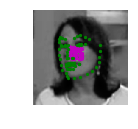

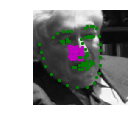

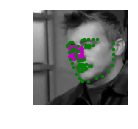

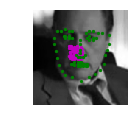

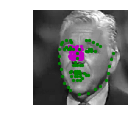

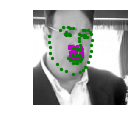

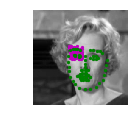

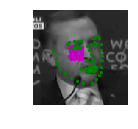

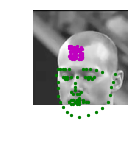

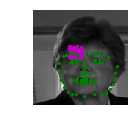

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
criterion = nn.SmoothL1Loss()      


## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate and some momentum
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adadelta(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr= 0.002)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
from workspace_utils import active_session, keep_awake

def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in keep_awake(range(n_epochs)):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})``` 

            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [14]:
#from workspace_utils import active_session, keep_awake
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

#for epoch in keep_awake(range(10)):
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.3035378411412239
Epoch: 1, Batch: 20, Avg. Loss: 0.2693867087364197
Epoch: 1, Batch: 30, Avg. Loss: 0.28030183762311933
Epoch: 1, Batch: 40, Avg. Loss: 0.28571955412626265
Epoch: 1, Batch: 50, Avg. Loss: 0.24277406930923462
Epoch: 1, Batch: 60, Avg. Loss: 0.21197488605976106
Epoch: 1, Batch: 70, Avg. Loss: 0.2071916326880455
Epoch: 1, Batch: 80, Avg. Loss: 0.1729506880044937
Epoch: 1, Batch: 90, Avg. Loss: 0.17907473891973497
Epoch: 1, Batch: 100, Avg. Loss: 0.14838472306728362
Epoch: 1, Batch: 110, Avg. Loss: 0.1515624403953552
Epoch: 1, Batch: 120, Avg. Loss: 0.15477252751588821
Epoch: 1, Batch: 130, Avg. Loss: 0.13968501463532448
Epoch: 1, Batch: 140, Avg. Loss: 0.12795380875468254
Epoch: 1, Batch: 150, Avg. Loss: 0.1511966697871685
Epoch: 1, Batch: 160, Avg. Loss: 0.12473903223872185
Epoch: 1, Batch: 170, Avg. Loss: 0.14124995172023774
Epoch: 1, Batch: 180, Avg. Loss: 0.12531424239277839
Epoch: 1, Batch: 190, Avg. Loss: 0.14353632032871247
Epoch: 1

Epoch: 5, Batch: 220, Avg. Loss: 0.0969373844563961
Epoch: 5, Batch: 230, Avg. Loss: 0.08742366395890713
Epoch: 5, Batch: 240, Avg. Loss: 0.08225227445363999
Epoch: 5, Batch: 250, Avg. Loss: 0.09712086282670498
Epoch: 5, Batch: 260, Avg. Loss: 0.09971999302506447
Epoch: 5, Batch: 270, Avg. Loss: 0.09614430591464043
Epoch: 5, Batch: 280, Avg. Loss: 0.08369915522634983
Epoch: 5, Batch: 290, Avg. Loss: 0.08065791688859462
Epoch: 5, Batch: 300, Avg. Loss: 0.08717849440872669
Epoch: 5, Batch: 310, Avg. Loss: 0.0832051157951355
Epoch: 5, Batch: 320, Avg. Loss: 0.08984112478792668
Epoch: 5, Batch: 330, Avg. Loss: 0.1031017329543829
Epoch: 5, Batch: 340, Avg. Loss: 0.09073386341333389
Epoch: 6, Batch: 10, Avg. Loss: 0.07845609411597251
Epoch: 6, Batch: 20, Avg. Loss: 0.0981722492724657
Epoch: 6, Batch: 30, Avg. Loss: 0.07277780808508397
Epoch: 6, Batch: 40, Avg. Loss: 0.0819494117051363
Epoch: 6, Batch: 50, Avg. Loss: 0.08766158074140548
Epoch: 6, Batch: 60, Avg. Loss: 0.09291129186749458
Epoc

Epoch: 10, Batch: 80, Avg. Loss: 0.10994897820055485
Epoch: 10, Batch: 90, Avg. Loss: 0.08844838291406631
Epoch: 10, Batch: 100, Avg. Loss: 0.06890893243253231
Epoch: 10, Batch: 110, Avg. Loss: 0.07941960766911507
Epoch: 10, Batch: 120, Avg. Loss: 0.09039605669677257
Epoch: 10, Batch: 130, Avg. Loss: 0.10266521275043487
Epoch: 10, Batch: 140, Avg. Loss: 0.08507961742579936
Epoch: 10, Batch: 150, Avg. Loss: 0.08542852699756623
Epoch: 10, Batch: 160, Avg. Loss: 0.08958611860871316
Epoch: 10, Batch: 170, Avg. Loss: 0.10543078891932964
Epoch: 10, Batch: 180, Avg. Loss: 0.08803811520338059
Epoch: 10, Batch: 190, Avg. Loss: 0.1166862327605486
Epoch: 10, Batch: 200, Avg. Loss: 0.0877654142677784
Epoch: 10, Batch: 210, Avg. Loss: 0.10747378841042518
Epoch: 10, Batch: 220, Avg. Loss: 0.09351787008345128
Epoch: 10, Batch: 230, Avg. Loss: 0.08820697478950024
Epoch: 10, Batch: 240, Avg. Loss: 0.116311464458704
Epoch: 10, Batch: 250, Avg. Loss: 0.08480003029108048
Epoch: 10, Batch: 260, Avg. Loss: 

Epoch: 14, Batch: 250, Avg. Loss: 0.07582346759736538
Epoch: 14, Batch: 260, Avg. Loss: 0.10099610537290574
Epoch: 14, Batch: 270, Avg. Loss: 0.09266378656029702
Epoch: 14, Batch: 280, Avg. Loss: 0.0891013614833355
Epoch: 14, Batch: 290, Avg. Loss: 0.07042605541646481
Epoch: 14, Batch: 300, Avg. Loss: 0.09684404358267784
Epoch: 14, Batch: 310, Avg. Loss: 0.07254672087728978
Epoch: 14, Batch: 320, Avg. Loss: 0.07954932861030102
Epoch: 14, Batch: 330, Avg. Loss: 0.11827301420271397
Epoch: 14, Batch: 340, Avg. Loss: 0.08553716577589512
Epoch: 15, Batch: 10, Avg. Loss: 0.09066588208079338
Epoch: 15, Batch: 20, Avg. Loss: 0.09432686306536198
Epoch: 15, Batch: 30, Avg. Loss: 0.08732348307967186
Epoch: 15, Batch: 40, Avg. Loss: 0.07558531947433948
Epoch: 15, Batch: 50, Avg. Loss: 0.08501305319368839
Epoch: 15, Batch: 60, Avg. Loss: 0.07742275521159173
Epoch: 15, Batch: 70, Avg. Loss: 0.08280766941606998
Epoch: 15, Batch: 80, Avg. Loss: 0.09669386558234691
Epoch: 15, Batch: 90, Avg. Loss: 0.08

Epoch: 19, Batch: 80, Avg. Loss: 0.09268935285508632
Epoch: 19, Batch: 90, Avg. Loss: 0.07548611126840114
Epoch: 19, Batch: 100, Avg. Loss: 0.07860895283520222
Epoch: 19, Batch: 110, Avg. Loss: 0.08485815301537514
Epoch: 19, Batch: 120, Avg. Loss: 0.08459161333739758
Epoch: 19, Batch: 130, Avg. Loss: 0.10128811746835709
Epoch: 19, Batch: 140, Avg. Loss: 0.0865097038447857
Epoch: 19, Batch: 150, Avg. Loss: 0.10019374713301658
Epoch: 19, Batch: 160, Avg. Loss: 0.09216955564916134
Epoch: 19, Batch: 170, Avg. Loss: 0.089952115342021
Epoch: 19, Batch: 180, Avg. Loss: 0.09309081137180328
Epoch: 19, Batch: 190, Avg. Loss: 0.09369231313467026
Epoch: 19, Batch: 200, Avg. Loss: 0.06704775281250477
Epoch: 19, Batch: 210, Avg. Loss: 0.10428623557090759
Epoch: 19, Batch: 220, Avg. Loss: 0.08711016327142715
Epoch: 19, Batch: 230, Avg. Loss: 0.09740999899804592
Epoch: 19, Batch: 240, Avg. Loss: 0.10315090604126453
Epoch: 19, Batch: 250, Avg. Loss: 0.10486750043928623
Epoch: 19, Batch: 260, Avg. Loss:

Epoch: 23, Batch: 250, Avg. Loss: 0.07967382036149502
Epoch: 23, Batch: 260, Avg. Loss: 0.06616603285074234
Epoch: 23, Batch: 270, Avg. Loss: 0.0903520431369543
Epoch: 23, Batch: 280, Avg. Loss: 0.09579789191484452
Epoch: 23, Batch: 290, Avg. Loss: 0.12137246206402778
Epoch: 23, Batch: 300, Avg. Loss: 0.0969695296138525
Epoch: 23, Batch: 310, Avg. Loss: 0.08998371176421642
Epoch: 23, Batch: 320, Avg. Loss: 0.08075170516967774
Epoch: 23, Batch: 330, Avg. Loss: 0.10287262462079524
Epoch: 23, Batch: 340, Avg. Loss: 0.08315397426486015
Epoch: 24, Batch: 10, Avg. Loss: 0.08302951157093048
Epoch: 24, Batch: 20, Avg. Loss: 0.09756173975765706
Epoch: 24, Batch: 30, Avg. Loss: 0.08480572700500488
Epoch: 24, Batch: 40, Avg. Loss: 0.08682837933301926
Epoch: 24, Batch: 50, Avg. Loss: 0.10535321943461895
Epoch: 24, Batch: 60, Avg. Loss: 0.09416006654500961
Epoch: 24, Batch: 70, Avg. Loss: 0.10082616768777371
Epoch: 24, Batch: 80, Avg. Loss: 0.10024462938308716
Epoch: 24, Batch: 90, Avg. Loss: 0.082

Epoch: 28, Batch: 80, Avg. Loss: 0.08686059154570103
Epoch: 28, Batch: 90, Avg. Loss: 0.07447492033243179
Epoch: 28, Batch: 100, Avg. Loss: 0.07445988208055496
Epoch: 28, Batch: 110, Avg. Loss: 0.074507737159729
Epoch: 28, Batch: 120, Avg. Loss: 0.08842663057148456
Epoch: 28, Batch: 130, Avg. Loss: 0.09261375516653061
Epoch: 28, Batch: 140, Avg. Loss: 0.12077615596354008
Epoch: 28, Batch: 150, Avg. Loss: 0.08749343380331993
Epoch: 28, Batch: 160, Avg. Loss: 0.09548023045063019
Epoch: 28, Batch: 170, Avg. Loss: 0.09611039385199546
Epoch: 28, Batch: 180, Avg. Loss: 0.08798464015126228
Epoch: 28, Batch: 190, Avg. Loss: 0.078306794911623
Epoch: 28, Batch: 200, Avg. Loss: 0.08680496923625469
Epoch: 28, Batch: 210, Avg. Loss: 0.07967178523540497
Epoch: 28, Batch: 220, Avg. Loss: 0.07574266009032726
Epoch: 28, Batch: 230, Avg. Loss: 0.10301670543849469
Epoch: 28, Batch: 240, Avg. Loss: 0.09631930142641068
Epoch: 28, Batch: 250, Avg. Loss: 0.08408736884593963
Epoch: 28, Batch: 260, Avg. Loss: 

Epoch: 32, Batch: 250, Avg. Loss: 0.1096582692116499
Epoch: 32, Batch: 260, Avg. Loss: 0.10108877196907998
Epoch: 32, Batch: 270, Avg. Loss: 0.07316660024225712
Epoch: 32, Batch: 280, Avg. Loss: 0.07765065841376781
Epoch: 32, Batch: 290, Avg. Loss: 0.0862043894827366
Epoch: 32, Batch: 300, Avg. Loss: 0.08891756534576416
Epoch: 32, Batch: 310, Avg. Loss: 0.08931034058332443
Epoch: 32, Batch: 320, Avg. Loss: 0.07392868679016829
Epoch: 32, Batch: 330, Avg. Loss: 0.1034960314631462
Epoch: 32, Batch: 340, Avg. Loss: 0.0884267345070839
Epoch: 33, Batch: 10, Avg. Loss: 0.08918617144227028
Epoch: 33, Batch: 20, Avg. Loss: 0.07055842205882072
Epoch: 33, Batch: 30, Avg. Loss: 0.08697481341660022
Epoch: 33, Batch: 40, Avg. Loss: 0.10977496765553951
Epoch: 33, Batch: 50, Avg. Loss: 0.08614121377468109
Epoch: 33, Batch: 60, Avg. Loss: 0.08507672175765038
Epoch: 33, Batch: 70, Avg. Loss: 0.09339658170938492
Epoch: 33, Batch: 80, Avg. Loss: 0.08747308924794198
Epoch: 33, Batch: 90, Avg. Loss: 0.09576

Epoch: 37, Batch: 90, Avg. Loss: 0.08483928404748439
Epoch: 37, Batch: 100, Avg. Loss: 0.08043773211538792
Epoch: 37, Batch: 110, Avg. Loss: 0.08785630241036416
Epoch: 37, Batch: 120, Avg. Loss: 0.07447458878159523
Epoch: 37, Batch: 130, Avg. Loss: 0.08154032193124294
Epoch: 37, Batch: 140, Avg. Loss: 0.087937381118536
Epoch: 37, Batch: 150, Avg. Loss: 0.09843921475112438
Epoch: 37, Batch: 160, Avg. Loss: 0.09186255410313607
Epoch: 37, Batch: 170, Avg. Loss: 0.0826593317091465
Epoch: 37, Batch: 180, Avg. Loss: 0.0861416444182396
Epoch: 37, Batch: 190, Avg. Loss: 0.0769309263676405
Epoch: 37, Batch: 200, Avg. Loss: 0.10613097101449967
Epoch: 37, Batch: 210, Avg. Loss: 0.09239424467086792
Epoch: 37, Batch: 220, Avg. Loss: 0.09495917446911335
Epoch: 37, Batch: 230, Avg. Loss: 0.0847722727805376
Epoch: 37, Batch: 240, Avg. Loss: 0.0799228236079216
Epoch: 37, Batch: 250, Avg. Loss: 0.08998671770095826
Epoch: 37, Batch: 260, Avg. Loss: 0.07576202042400837
Epoch: 37, Batch: 270, Avg. Loss: 0.

Epoch: 41, Batch: 260, Avg. Loss: 0.10853097327053547
Epoch: 41, Batch: 270, Avg. Loss: 0.0988524504005909
Epoch: 41, Batch: 280, Avg. Loss: 0.09250211194157601
Epoch: 41, Batch: 290, Avg. Loss: 0.07101687416434288
Epoch: 41, Batch: 300, Avg. Loss: 0.09975277073681355
Epoch: 41, Batch: 310, Avg. Loss: 0.08164567723870278
Epoch: 41, Batch: 320, Avg. Loss: 0.08497451320290565
Epoch: 41, Batch: 330, Avg. Loss: 0.09100189842283726
Epoch: 41, Batch: 340, Avg. Loss: 0.08583901897072792
Epoch: 42, Batch: 10, Avg. Loss: 0.10161441937088966
Epoch: 42, Batch: 20, Avg. Loss: 0.07821724116802216
Epoch: 42, Batch: 30, Avg. Loss: 0.08245211355388164
Epoch: 42, Batch: 40, Avg. Loss: 0.10258681997656822
Epoch: 42, Batch: 50, Avg. Loss: 0.07088252380490304
Epoch: 42, Batch: 60, Avg. Loss: 0.07670250646770001
Epoch: 42, Batch: 70, Avg. Loss: 0.08949172720313073
Epoch: 42, Batch: 80, Avg. Loss: 0.0898706253618002
Epoch: 42, Batch: 90, Avg. Loss: 0.08357290029525757
Epoch: 42, Batch: 100, Avg. Loss: 0.072

Epoch: 46, Batch: 90, Avg. Loss: 0.09131714254617691
Epoch: 46, Batch: 100, Avg. Loss: 0.1044392477720976
Epoch: 46, Batch: 110, Avg. Loss: 0.06732999049127102
Epoch: 46, Batch: 120, Avg. Loss: 0.09886625707149506
Epoch: 46, Batch: 130, Avg. Loss: 0.09029635898768902
Epoch: 46, Batch: 140, Avg. Loss: 0.1214263267815113
Epoch: 46, Batch: 150, Avg. Loss: 0.09344699941575527
Epoch: 46, Batch: 160, Avg. Loss: 0.09144531562924385
Epoch: 46, Batch: 170, Avg. Loss: 0.09220762699842452
Epoch: 46, Batch: 180, Avg. Loss: 0.11157440096139908
Epoch: 46, Batch: 190, Avg. Loss: 0.09230037182569503
Epoch: 46, Batch: 200, Avg. Loss: 0.09505966678261757
Epoch: 46, Batch: 210, Avg. Loss: 0.08741426691412926
Epoch: 46, Batch: 220, Avg. Loss: 0.09777540676295757
Epoch: 46, Batch: 230, Avg. Loss: 0.07747008465230465
Epoch: 46, Batch: 240, Avg. Loss: 0.09637018367648124
Epoch: 46, Batch: 250, Avg. Loss: 0.08688219524919986
Epoch: 46, Batch: 260, Avg. Loss: 0.0902628868818283
Epoch: 46, Batch: 270, Avg. Loss

Epoch: 50, Batch: 260, Avg. Loss: 0.08946428876370191
Epoch: 50, Batch: 270, Avg. Loss: 0.0899750154465437
Epoch: 50, Batch: 280, Avg. Loss: 0.08764048926532268
Epoch: 50, Batch: 290, Avg. Loss: 0.08263713233172894
Epoch: 50, Batch: 300, Avg. Loss: 0.11516217440366745
Epoch: 50, Batch: 310, Avg. Loss: 0.10363866314291954
Epoch: 50, Batch: 320, Avg. Loss: 0.08888957016170025
Epoch: 50, Batch: 330, Avg. Loss: 0.07522011063992977
Epoch: 50, Batch: 340, Avg. Loss: 0.09086654670536518
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


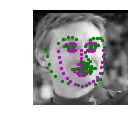

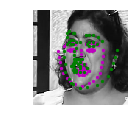

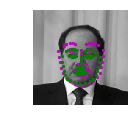

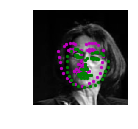

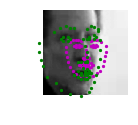

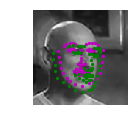

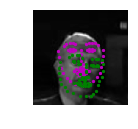

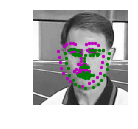

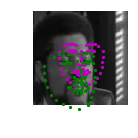

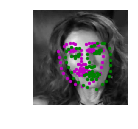

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [17]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.17554007  0.14222097  0.10698681 -0.02833393 -0.05969006]
 [ 0.18108024  0.06829134 -0.14756732  0.12940058 -0.04393778]
 [ 0.06487902  0.17330983 -0.03013832  0.07994347 -0.13148578]
 [ 0.06369745  0.15507263 -0.1441513   0.01080282 -0.17404462]
 [-0.15771985 -0.08260916 -0.14431895  0.0417689   0.05269885]]
(5, 5)


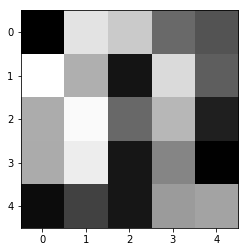

In [18]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

[[ 0.13422993  0.11470097 -0.1013016  -0.01373374 -0.00917922]
 [ 0.13155465 -0.09790795  0.18207261 -0.02982962  0.04605509]
 [ 0.11914157 -0.18061972 -0.056088   -0.1670814  -0.15405692]
 [-0.16648331  0.08705072  0.07914206  0.18035829 -0.01822996]
 [ 0.12552659 -0.17020577  0.10575175 -0.13353264  0.02158395]]
(5, 5)


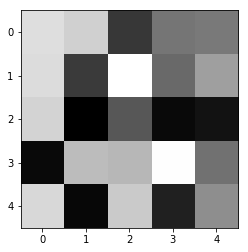

In [19]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!